This notebook domonstrates that `LDLsolver` can be vectorized

In [1]:
using LinearAlgebra
using SparseArrays
using Statistics
import Laplacians as Lap
include("Laplacians.jl/src/Laplacians.jl")
import .Laplacians as LapM
import Random
using Plots
using BenchmarkTools
using CUDA, CUDA.CUSPARSE
using Profile

First, construct a graph and build the original solver. Apply the solver to the graph laplacian to get some result as reference.

In [7]:
NUMNODES = 10000
a = Lap.pure_random_graph(NUMNODES)

Random.seed!(1234) # fix the seed
originalGetLDLi(mat) = Lap.approxChol(Lap.LLmatp(mat))
originalApplyLDLi(ldli, mat) = sparse(reduce(hcat, map(x -> Lap.LDLsolver(ldli, Vector(x)), eachcol(mat))))
originalApplyLDLiPartial(ldli, mat) = sparse(reduce(hcat, map(x -> Lap.LDLsolver(ldli, Vector(x)), eachcol(mat[:, 1:10]))))
refLDL = originalGetLDLi(a)
reflap = Lap.lap(a)
refResult = originalApplyLDLiPartial(refLDL, reflap)
refResult[1:10, 1:10]

10×10 SparseMatrixCSC{Float64, Int64} with 100 stored entries:
  1.19939      -0.00093551    0.00951822   …  -0.0021212     4.28757e-5
 -0.000927191   0.789211      0.00036962       5.10934e-5   -0.000259974
 -0.00570306   -0.00132487    0.839549         0.000321934  -2.26799e-5
 -0.000609956   0.00363344    0.0004635       -0.00124805   -0.000250028
 -0.000358313   0.0137124     0.00221085      -0.000479112  -7.97074e-5
 -0.000172016  -0.000756344   0.00165061   …  -0.00106195   -0.00010058
 -0.00288473    0.0159633    -0.00192734       7.25557e-5   -8.84859e-5
 -0.000253324  -0.00203778   -0.00283071       0.000977341  -0.000102912
 -0.00117134    5.1579e-5     0.000428448      0.954253      0.000899641
  0.000234322  -0.00149917    0.000257316      0.00533497    1.12454

Then, build the modified solver (vectorized). Also apply the solver to the graph laplacian to get the result

In [8]:
Random.seed!(1234) # fix the seed
vecGetLDLi(mat) = LapM.approxChol(LapM.LLmatp(mat))
vecApplyLDLi(ldli, mat) = sparse(reduce(hcat, map(x -> LapM.LDLsolver(ldli, Vector(x)), eachcol(mat))))
vecApplyLDLiPartial(ldli, mat) = sparse(reduce(hcat, map(x -> LapM.LDLsolver(ldli, Vector(x)), eachcol(mat[:, 1:10]))))
vecLDL = vecGetLDLi(a)
vecLen = LapM.preprocessLDL(vecLDL)
vecLap = LapM.lap(a)
vecResult = vecApplyLDLiPartial(vecLDL, LapM.lap(a))
vecResult[1:10, 1:10]

10×10 SparseMatrixCSC{Float64, Int64} with 100 stored entries:
  1.19939      -0.00093551    0.00951822   …  -0.0021212     4.28757e-5
 -0.000927191   0.789211      0.00036962       5.10934e-5   -0.000259974
 -0.00570306   -0.00132487    0.839549         0.000321934  -2.26799e-5
 -0.000609956   0.00363344    0.0004635       -0.00124805   -0.000250028
 -0.000358313   0.0137124     0.00221085      -0.000479112  -7.97074e-5
 -0.000172016  -0.000756344   0.00165061   …  -0.00106195   -0.00010058
 -0.00288473    0.0159633    -0.00192734       7.25557e-5   -8.84859e-5
 -0.000253324  -0.00203778   -0.00283071       0.000977341  -0.000102912
 -0.00117134    5.1579e-5     0.000428448      0.954253      0.000899641
  0.000234322  -0.00149917    0.000257316      0.00533497    1.12454

Finally, check do they approximate with each other (there may be error due to reordering of floating points operations)

In [9]:
refResult ≈ vecResult

true

In [10]:
refResult == vecResult

false

In [11]:
maximum(abs.(refResult - vecResult))

4.440892098500626e-16

# Analysis for the solver

Although the solver in Laplacians.jl library is already fast, it is still significantly slower than the GPU accelerated matrix vector multiplication operation

In [7]:
rn = randn(NUMNODES)
@benchmark Lap.LDLsolver(refLDL, rn)

BenchmarkTools.Trial: 197 samples with 1 evaluation.
 Range (min … max):  24.371 ms … 32.624 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     24.935 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   25.410 ms ±  1.187 ms  ┊ GC (mean ± σ):  0.15% ± 1.14%

    ▄█▄▄ ▁                                                     
  ▆█████▅█▆▃▂▃▂▁▃▄▄▅▆▆▅▄▃▄▁▁▁▂▁▁▁▂▁▃▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▂▁▁▁▁▁▂ ▂
  24.4 ms         Histogram: frequency by time        30.5 ms <

 Memory estimate: 7.63 MiB, allocs estimate: 2.

In [8]:
@profile Lap.LDLsolver(refLDL, rn)

1000000-element Vector{Float64}:
  345.56327699195117
  342.2398371170152
  350.19837301455937
  343.7707411547153
  344.6196189795264
  342.8324561125737
  341.6647808988705
  343.1613012843891
  340.63135871088707
  344.9000962726177
  350.00693787541877
  346.38364094766257
  346.9784246186814
    ⋮
 -668.4726642992966
 -668.793437694716
 -673.5152304115115
 -673.6049946273276
 -682.1723001639541
 -681.1224509042786
 -666.067910199398
 -670.2842925361763
 -667.6848510760851
 -668.6970133650777
 -675.2182621012162
 -676.4580298232313

In [11]:
Profile.print()

Overhead ╎ [+additional indent] Count File:Line; Function
   ╎7   @Base/task.jl:484; (::IJulia.var"#15#18")()
   ╎ 7   @IJulia/src/eventloop.jl:8; eventloop(socket::ZMQ.Socket)
   ╎  7   @Base/essentials.jl:726; invokelatest
   ╎   7   @Base/essentials.jl:729; #invokelatest#2
   ╎    7   .../execute_request.jl:67; execute_request(socket::ZMQ.So...
   ╎     7   .../SoftGlobalScope.jl:65; softscope_include_string(m::Mo...
   ╎    ╎ 7   @Base/loading.jl:1428; include_string(mapexpr::type...
  1╎    ╎  7   @Base/boot.jl:368; eval
   ╎    ╎   1   ...src/approxChol.jl:576; LDLsolver(ldli::Laplacians....
  1╎    ╎    1   @Base/array.jl:966; setindex!
   ╎    ╎   5   ...src/approxChol.jl:580; LDLsolver(ldli::Laplacians....
   ╎    ╎    1   ...src/approxChol.jl:617; backward!(ldli::Laplacians....
  1╎    ╎     1   @Base/array.jl:924; getindex
   ╎    ╎    3   ...src/approxChol.jl:624; backward!(ldli::Laplacians....
   ╎    ╎     3   @Base/range.jl:22; Colon
   ╎    ╎    ╎ 3   @Base/range.jl:24;

In [9]:
cua = CuSparseMatrixCSC(a)
cuv = CuVector(randn(NUMNODES))

1000000-element CuArray{Float64, 1, CUDA.Mem.DeviceBuffer}:
 -0.031018542461611964
  0.22491859467243158
  0.395496470936462
  0.052089168568734225
 -0.017687945158850207
 -0.155539314666318
 -0.17362990888286758
 -0.31360275114425235
  0.3501509956841262
 -0.5494549135232003
 -0.0769803153563407
 -1.0726595753519235
  2.067802108063549
  ⋮
 -1.757470183503019
  0.6076513284772025
  1.2406651052942987
  0.21683788319214722
 -0.7450782170944629
 -0.3522778738059448
  1.5998878972023436
  0.08940374273585208
 -0.6438638757225565
  0.8142669211861717
 -0.4643868078200343
  0.5548553594563295

In [10]:
@benchmark CUDA.@sync cua * cuv

BenchmarkTools.Trial: 3255 samples with 1 evaluation.
 Range (min … max):  256.740 μs … 35.047 ms  ┊ GC (min … max): 0.00% … 50.40%
 Time  (median):       1.486 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):     1.529 ms ±  1.132 ms  ┊ GC (mean ± σ):  0.35% ±  0.88%

                     ▃▁▄ ▃█▅                                    
  ▇▂▂▁▁▁▁▁▁▁▂▂▃▃▄▄▅▅▇████████▆▇▇█▅▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂ ▃
  257 μs          Histogram: frequency by time         3.35 ms <

 Memory estimate: 1008 bytes, allocs estimate: 50.

a

In most of the iterations, only few operations are done.

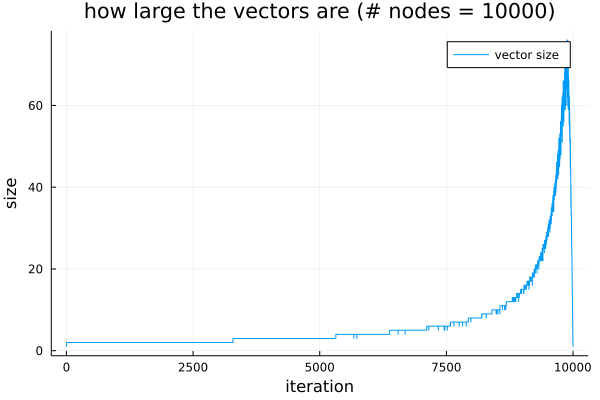

In [59]:
plot(1:length(vecLen), vecLen; 
    label="vector size", xlabel="iteration", ylabel="size", 
    title="how large the vectors are (# nodes = $(NUMNODES))", size=(600,400))

Based on this observation, we can expect even if we batches multiple iterations, the possibility of conflicts are not high.

In [26]:
function lasteq(l, st, ed, v)
    for i in ed:-1:st
        if l[i] == v
            return i
        end
    end
    return 0
end

lasteq (generic function with 1 method)

In [27]:
prevComp = similar(vecLDL.col)
for it in 1:length(prevComp)
    i = vecLDL.col[it]
    ed = vecLDL.colptr[it]
    prevComp[it] = ed - lasteq(vecLDL.rowval, 1, ed, i)
end

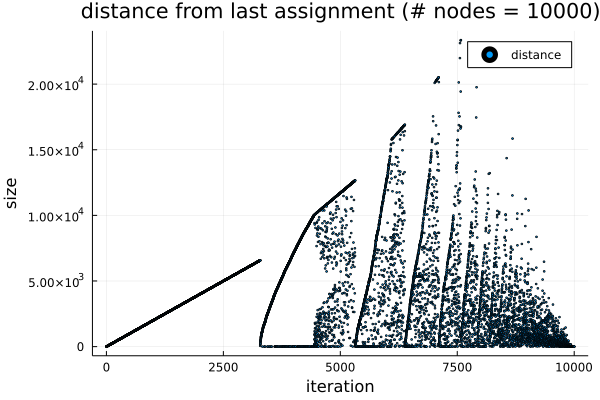

In [32]:
scatter(1:length(prevComp), prevComp; 
    label="distance", xlabel="iteration", ylabel="size", 
    title="distance from last assignment (# nodes = $(NUMNODES))", size=(600,400), markersize = 1)

In [13]:
mean(prevComp)

13099.054405440544

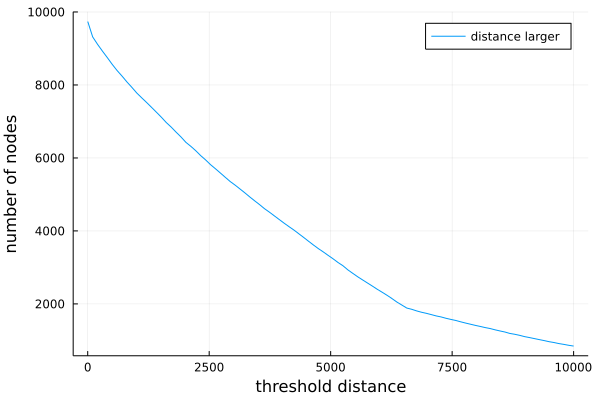

In [43]:
perComp = [sum(prevComp .> i) for i in range(start=1, stop=10000, length = 100)]
plot(range(start=1, stop=10000, length=100), perComp; label="distance larger", xlabel="threshold distance", ylabel="number of nodes")

In [19]:
function numeq(l, st, ed, v)
    c = 0
    for i in st:ed
        if l[i] == v
            c = c + 1
        end
    end
    return c
end

numeq (generic function with 1 method)

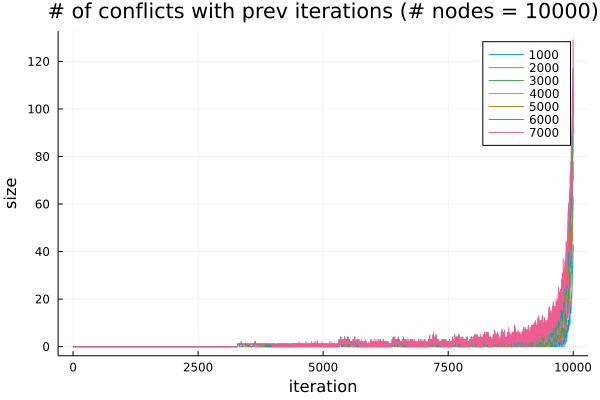

In [61]:
plot()
for n in 1000:1000:7000
    numConf = similar(vecLDL.col)
    for it in 1:length(numConf)
        i = vecLDL.col[it]
        ed = vecLDL.colptr[it]
        numConf[it] = numeq(vecLDL.rowval, max(1, ed-n), ed, i)
    end
    plot!(1:length(numConf), numConf; 
        label="$(n)", xlabel="iteration", ylabel="size", 
        title="# of conflicts with prev iterations (# nodes = $(NUMNODES))", size=(600,400))
end
plot!()

In [68]:
mn = Vector{Float64}(undef, 8)
for n in 1000:1000:7000
    numConf = similar(vecLDL.col)
    for it in 1:length(numConf)
        i = vecLDL.col[it]
        ed = vecLDL.colptr[it]
        numConf[it] = numeq(vecLDL.rowval, max(1, ed-n), ed, i)
    end
    mn[n ÷ 1000] = mean(numConf)
end
plot(1000:1000:7000, mn)

BoundsError: BoundsError: attempt to access 7-element StepRange{Int64, Int64} at index [1:8]

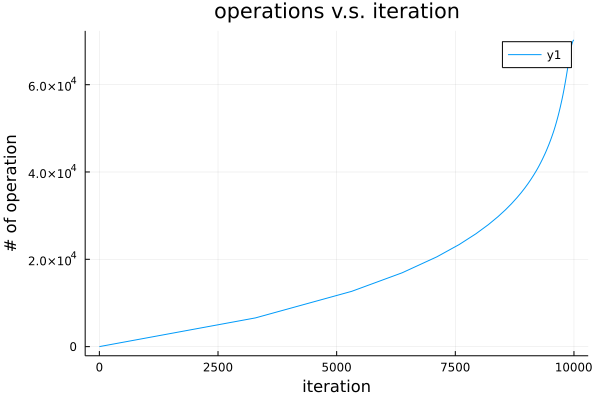

In [62]:
plot(1:length(vecLDL.colptr), vecLDL.colptr; title="operations v.s. iteration", ylabel="# of operation", xlabel="iteration")

Let us analyze the forward!() method first as we can analyze the confliction easier

In [63]:
length(vecLDL.rowval)

70219

In [64]:
sprandn(NUMNODES, NUMNODES, 0.2)

10000×10000 SparseMatrixCSC{Float64, Int64} with 19993463 stored entries:
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿